In [ ]:
!pip install stable-baselines3
!pip install git+https://github.com/indrasweb/expert-offline-rl.git

In [2]:
import numpy as np
from google.colab import drive
import gym
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
import datetime
from eorl import OfflineDataset

import torch as T
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack, VecTransposeImage
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.buffers import ReplayBuffer

In [3]:
ENV_NAME = 'PongNoFrameskip-v4'
DS_NAME = 'Pong'
SAVE_DIR = 'gdrive/MyDrive/SQIL/Imitation/Pong'

SEED = 1337             # torch, np and py seeds
ONLINE_STEPS = 2e6      # total env steps to train for (2 million)
EXPERT_STEPS = 3e5      # total expert steps to mix into replay buffer
BATCH_SIZE = 32         # steps in each train batch
GAMMA = 0.99            # reward discounting coefficient
MEM_SIZE = 25000        # replay memory size
TARGET_UPDATE = 10000   # steps between target updates
LEARNING_STARTS = 20000 # number of steps before learning starts
TRAIN_FREQUENCY = 4     # number of steps between behaviour policy updates
EPS_START = 1           # begin by taking completely random actions...
EPS_END = 0.1           # end by taking random actions 10% of time...
EPS_DECAY = 500000      # after 500,000 env steps.

In [4]:
DEVICE = T.device('cuda' if T.cuda.is_available() else 'cpu')
print('Using', DEVICE)

drive.mount('/content/gdrive/')
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

set_random_seed(SEED)

ds = OfflineDataset(
    DS_NAME, 
    dataset_size=EXPERT_STEPS, 
    framestack=4, 
    shuffle=True
)

Using cuda
Mounted at /content/gdrive/
downloading data...
decompressing data...


In [5]:
class Logger:

    def __init__(self, print_rate=250):
        self.log = {'ep_r':[], 'ep_l':[], 'loss':[]}
        self.n_ep = 0              # total games/episodes
        self.n_update = 1          # total weight updates
        self.n_frames = 0          # env steps (total from checkpoint)
        self.run_frames = 0        # env steps (for this run)
        self.max_rwd = -np.inf     # max rwd out of all games played
        self.start_time = time()   # time we started *this* run
        self.last_checkpoint = 0   # total_frames at last checkpoint
        self.print_rate = print_rate

    def eta(self):  # get hh:mm:ss left to train
        elapsed_time = time() - self.start_time
        frames_left = ONLINE_STEPS - self.n_frames
        sec_per_frame = elapsed_time / self.n_frames
        sec_left = int(frames_left * sec_per_frame)
        eta_str = str(datetime.timedelta(seconds=sec_left))
        return eta_str

    def fps(self):  # get frames per second
        elapsed_time = time() - self.start_time
        fps = int(self.run_frames / elapsed_time)
        return fps

    def sma(self, x):  # simple moving average
        if not x: return 0
        div = 50 if len(x) > 50 else len(x)
        return sum(list(zip(*x[-div:]))[-1])/div

    def print_log(self):
        fps = self.fps()
        eta = self.eta()
        print('-'*10, self.n_update, '/', ONLINE_STEPS, '-'*10)
        print('Num Games:', self.n_ep)
        print('Num Frames:', self.n_frames)
        print('FPS:', fps)
        print('ETA:', eta)
        print(f'SMA Length: {self.sma(self.log["ep_l"]):.3f}')
        print(f'SMA Reward: {self.sma(self.log["ep_r"]):.3f}')
        print(f'SMA Loss: {self.sma(self.log["loss"]):.3f}')
        print('Max reward:', self.max_rwd)

    def record(self, ep, loss):
        
        self.n_update += 1
        self.n_frames += 1
        self.run_frames += 1
        fr = (self.n_frames, self.n_update)

        # stats about finished episodes/games
        if ep:
            self.log['ep_l'].append(fr+(ep['l'],))
            self.log['ep_r'].append(fr+(ep['r'],))
            if ep['r'] > self.max_rwd: self.max_rwd = ep['r']
            self.n_ep += 1
             
        # nn training statistics
        if loss:
            self.log['loss'].append(fr+(loss,))
        
        # print log
        if self.n_update % self.print_rate == 0:
            self.print_log()

In [6]:
def ob_to_torch(x):
    x = T.from_numpy(x).float()
    x = x.to(DEVICE)
    return x

class DDQN(nn.Module):

    def __init__(self, in_shape, num_actions):
        super(DDQN, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_shape[0], 32, 8, 4),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2),
            nn.ReLU(True),
            nn.Conv2d(64, 64, 3, 1),
            nn.ReLU(True),
            nn.Conv2d(64, 1024, 7, 1),
            nn.ReLU(True),
            nn.Flatten()
        )
        self.flat_size = self.conv(T.rand(1, *in_shape)).size(1)
        self.split = self.flat_size//2
        self.value = nn.Linear(self.split, 1)
        self.advantage = nn.Linear(self.split, num_actions)
        self.apply(self.weights_init)  # important

    @staticmethod
    def weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')

    def forward(self, x):
        x = self.conv(x)
        v_split = x[:,:self.split]
        a_split = x[:,self.split:]
        v = self.value(v_split)
        a = self.advantage(a_split)
        a = a - T.mean(a, 1, keepdim=True)
        q_value = v + a
        return q_value

In [7]:
def new_run():
    # setup gym environment (MaxAndSkip=4 by default)
    env = make_atari_env(ENV_NAME, seed=SEED, monitor_dir=SAVE_DIR+ENV_NAME)
    # env = VecTransposeImage(env)
    env = VecFrameStack(env, n_stack=4)
    env = VecTransposeImage(env)
    env.observation_space.dtype = np.float32
    obs_space = env.observation_space
    act_space = env.action_space
    n_actions = act_space.n
    buf = ReplayBuffer(MEM_SIZE, obs_space, act_space, DEVICE)
    logger = Logger()

    # setup dueling Q-networks
    policy_net = DDQN(obs_space.shape, n_actions).to(DEVICE)
    target_net = DDQN(obs_space.shape, n_actions).to(DEVICE)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    optim = Adam(policy_net.parameters(), lr=1e-4)

    return env, buf, policy_net, target_net, optim, n_actions, logger

In [8]:
env, replay_buffer, policy, target, optim, n_actions, logger = new_run()
obs = env.reset()/255

In [9]:
for step in range(int(ONLINE_STEPS)):

    # epsilon greedy choose next action
    eps = EPS_END + (EPS_START-EPS_END)*np.exp(-1.*step/EPS_DECAY)
    if np.random.random() > eps:
        with T.no_grad(): action = policy(ob_to_torch(obs)).max(1)[1].item()
    else:
        action = np.random.randint(n_actions)

    # step env and store transition
    next_obs, rwd, done, info = env.step([action])
    next_obs = next_obs/255
    replay_buffer.add(obs, next_obs, action, rwd, done)
    obs = next_obs
    ep = info[0].get('episode')

    # train model
    if step > LEARNING_STARTS and step % TRAIN_FREQUENCY == 0:
        mb = replay_buffer.sample(BATCH_SIZE//2)
        # SQIL: sample expert data w/ reward == 1 and all online data == 0
        e_obs, e_acts, _, e_dones, e_next_obs = ds.batch(BATCH_SIZE//2)
        B_obs = T.cat((mb.observations, ob_to_torch(e_obs/255)))
        B_next_obs = T.cat((mb.next_observations, ob_to_torch(e_next_obs/255)))
        B_actions = T.cat((mb.actions, T.from_numpy(e_acts[:,None]).to(DEVICE)))
        B_rewards = T.cat((T.zeros_like(mb.rewards), T.ones_like(mb.rewards)))
        # get q-values of our taken actions
        q_obs = policy(B_obs).gather(1, B_actions)
        # pretend we follow the greedy policy after taking those actions
        greedy_actions = policy(B_next_obs).max(1)[1].view(-1,1)
        # stabilise q estimates with target network
        q_next_obs = target(B_next_obs).gather(1, greedy_actions)
        # estimated (discounted) future total reward of next_obs
        expected_future_reward = q_next_obs*GAMMA + B_rewards
        # optimize our Q-network for more accurate Q-values
        loss = F.smooth_l1_loss(q_obs, expected_future_reward)

        optim.zero_grad()
        loss.backward()
        # gradient clipping
        nn.utils.clip_grad_norm_(policy.parameters(), 1)
        optim.step()
        logger.record(ep, loss.item())
    elif step > LEARNING_STARTS:
        logger.record(ep, None)

    # update target network
    if step % TARGET_UPDATE == 0:
        target.load_state_dict(policy.state_dict())

Streaming output truncated to the last 5000 lines.
ETA: 0:23:19
SMA Length: 3725.580
SMA Reward: -19.960
SMA Loss: 0.406
Max reward: -16.0
---------- 1841500 / 2000000.0 ----------
Num Games: 2051
Num Frames: 1841499
FPS: 113
ETA: 0:23:17
SMA Length: 3725.580
SMA Reward: -19.960
SMA Loss: 0.348
Max reward: -16.0
---------- 1841750 / 2000000.0 ----------
Num Games: 2051
Num Frames: 1841749
FPS: 113
ETA: 0:23:15
SMA Length: 3725.580
SMA Reward: -19.960
SMA Loss: 0.364
Max reward: -16.0
---------- 1842000 / 2000000.0 ----------
Num Games: 2052
Num Frames: 1841999
FPS: 113
ETA: 0:23:13
SMA Length: 3725.400
SMA Reward: -19.960
SMA Loss: 0.342
Max reward: -16.0
---------- 1842250 / 2000000.0 ----------
Num Games: 2052
Num Frames: 1842249
FPS: 113
ETA: 0:23:11
SMA Length: 3725.400
SMA Reward: -19.960
SMA Loss: 0.362
Max reward: -16.0
---------- 1842500 / 2000000.0 ----------
Num Games: 2052
Num Frames: 1842499
FPS: 113
ETA: 0:23:08
SMA Length: 3725.400
SMA Reward: -19.960
SMA Loss: 0.285
Max 

In [10]:
checkpoint = {
    'policy': policy.state_dict(),
    'optim': optim.state_dict(),
    'logger': logger
}
T.save(checkpoint, SAVE_DIR+ENV_NAME+'.final_checkpoint')

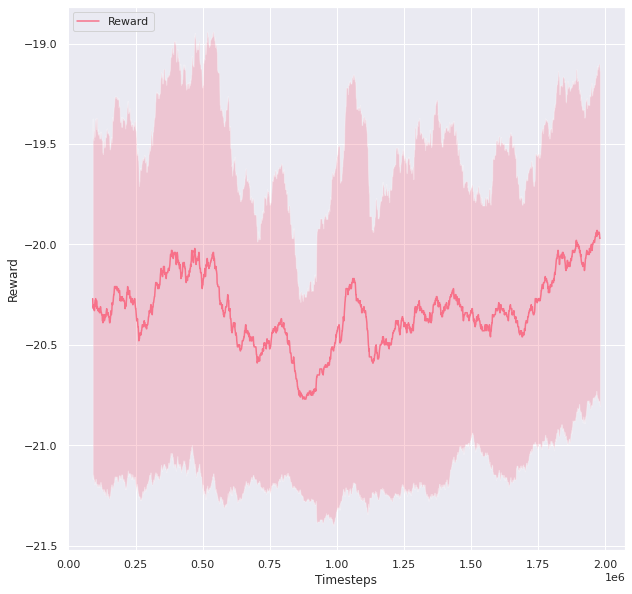

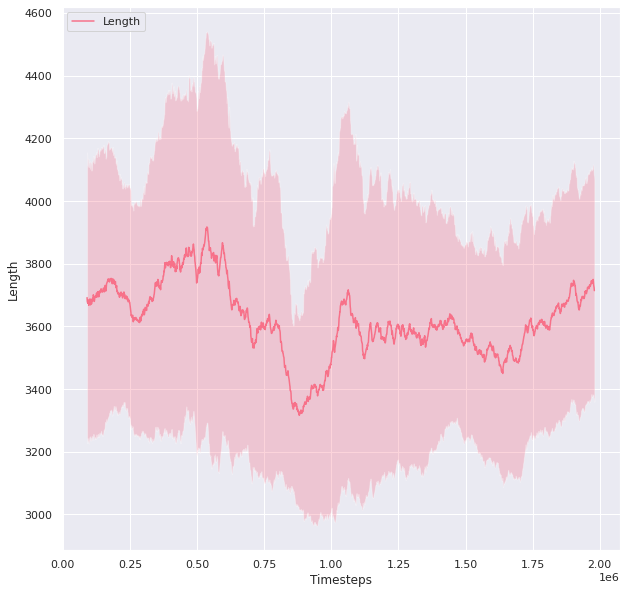

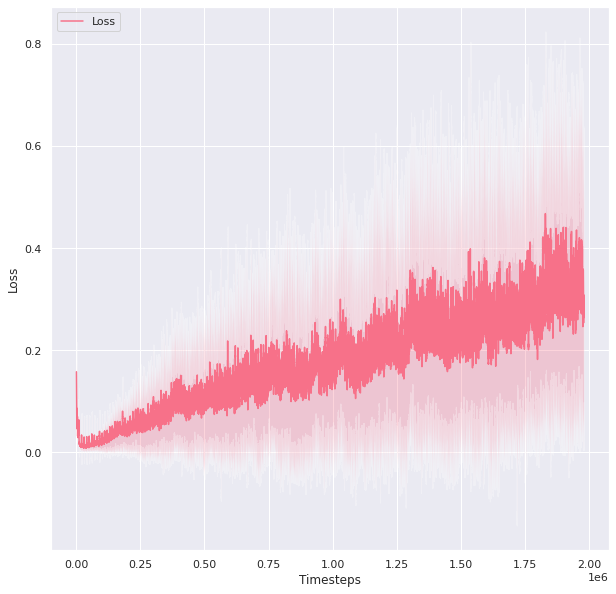

In [11]:
def plot_log(log, ylabel):
    sns.set()

    # compute rolling avg and std
    df = pd.DataFrame(log, columns =['Steps', 'Iters', ylabel])
    sma_y = df[ylabel].rolling(100).mean()
    std_y = df[ylabel].rolling(100).std()
    
    # plot with seaborn
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xlabel('Timesteps')
    ax.set_ylabel(ylabel)
    clrs = sns.color_palette("husl", 8)

    # fill standard deviation
    ax.plot(df['Steps'], sma_y, label=ylabel, c=clrs[0])
    ax.fill_between(df['Steps'], sma_y-std_y,  sma_y+std_y, 
                    alpha=0.3, facecolor=clrs[0]) 
    ax.legend(loc='upper left')
    plt.savefig(SAVE_DIR+ENV_NAME+'.'+ylabel+'.plt.png', 
                dpi=300, pad_inches=0)
    plt.show()

plot_log(logger.log['ep_r'], 'Reward')
plot_log(logger.log['ep_l'], 'Length')
plot_log(logger.log['loss'], 'Loss')